In [ ]:
import nltk  
nltk.download()

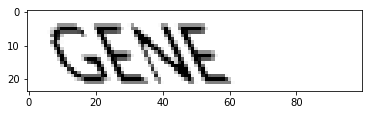

In [68]:
##  绘制验证码
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from skimage import transform as tf

def create_captcha(text, shear=0, size=(100, 24)):
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    #font = ImageFont.truetype(r"D:/Program Files (x86)/Python/practice/font/dancing-font/DancingScript-Regular.ttf", 22)
    font = ImageFont.truetype(r"D:/Program Files (x86)/Python/practice/font/carlito/Carlito-Regular.ttf", 22)
    draw.text((2, 2), text, fill=1, font=font)
    image = np.array(im)
    '''错切效果'''
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    return image / image.max()
%matplotlib inline
from matplotlib import pyplot as plt
image = create_captcha("GENE", shear=0.5)
plt.imshow(image, cmap='Greys')

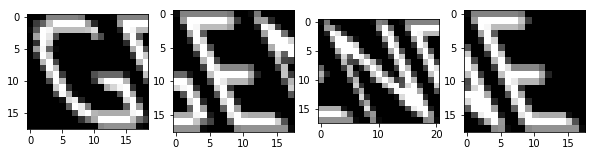

In [75]:
##  切分验证码
from skimage.measure import label, regionprops
def segment_image(image):
    labeled_image = label(image > 0)
    subimages = []
    for region in regionprops(labeled_image):
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x,start_y:end_y])
    if len(subimages) == 0:
        return [image,]
    f, axes = plt.subplots(1, len(subimages), figsize=(10, 3))
    for i in range(len(subimages)):
        axes[i].imshow(subimages[i], cmap="gray")
    plt.show()
    return subimages
subimages = segment_image(image)

#for i in range(len(subimages)):
#    axes[i].imshow(subimages[i], cmap="gray")

The target for this image is: 11
(12, 7, 6, 8, 23)
  (0, 12)	1.0
  (1, 7)	1.0
  (2, 6)	1.0
  (3, 8)	1.0
  (4, 23)	1.0
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  1.  0.  0.]]


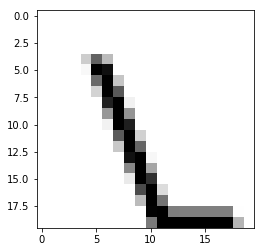

In [76]:
##  创建训练集
from sklearn.utils import check_random_state
random_state = check_random_state(14)
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
shear_values = np.arange(0, 0.5, 0.05)
def generate_sample(random_state=None):
    random_state = check_random_state(random_state)
    letter = random_state.choice(letters)
    shear = random_state.choice(shear_values)
    return create_captcha(letter, shear=shear, size=(20, 20)), letters.index(letter)
image, target = generate_sample(random_state)
plt.imshow(image, cmap="Greys")
print("The target for this image is: {0}".format(target))

dataset, targets = zip(*(generate_sample(random_state) for i in range(3000)))
print(targets[:5])
dataset = np.array(dataset, dtype='float')
targets = np.array(targets)

from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
y = onehot.fit_transform(targets.reshape(targets.shape[0],1))
print(y[:5])
y = y.todense()
print(y[:5])

In [37]:
##  根据抽取方法调整训练数据集
from skimage.transform import resize
dataset = np.array([resize(segment_image(sample)[0], (20, 20), mode='reflect') for sample in dataset]) 
#[0]???? because segment_image(sample) is a list of single elemnet, so list[0] is a array which have the attr.shape

X = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)


In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    '''if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)'''

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [39]:
##  使用pybrain训练分类
from pybrain.datasets import SupervisedDataSet
training = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_train.shape[0]):
    training.addSample(X_train[i], y_train[i])
testing = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_test.shape[0]):
    testing.addSample(X_test[i], y_test[i])


In [40]:

from pybrain.tools.shortcuts import buildNetwork
net = buildNetwork(X.shape[1], 100, y.shape[1], bias=True)

from pybrain.supervised.trainers import BackpropTrainer
trainer = BackpropTrainer(net, training, learningrate=0.01, weightdecay=0.01)
trainer.trainEpochs(epochs=20)
predictions = trainer.testOnClassData(dataset=testing)


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       1.00      1.00      1.00         7
          1       1.00      1.00      1.00         6
          2       1.00      1.00      1.00        13
          3       1.00      1.00      1.00         9
          4       1.00      1.00      1.00         8
          5       1.00      1.00      1.00         8
          6       1.00      1.00      1.00        11
          7       1.00      1.00      1.00        15
          8       0.95      1.00      0.97        18
          9       1.00      0.93      0.96        14
         10       1.00      1.00      1.00        11
         11       1.00      1.00      1.00        15
         12       1.00      1.00      1.00         6
         13       1.00      1.00      1.00        20
         14       0.45      1.00      0.62        10
         15       1.00      1.00      1.00        13
         16       0.00      0.00      0.00        12
         17       1.00      1.00      1.00   

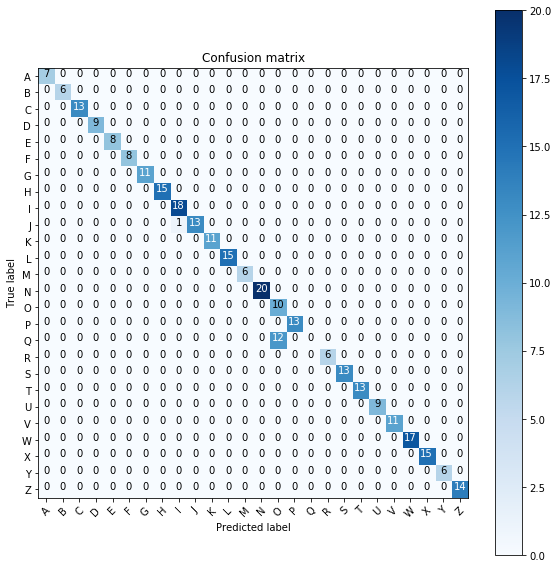

In [41]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
decoded_y_train = np.array(y_train.dot(onehot.active_features_).astype(int), dtype=int).reshape(-1)
decoded_y_test = np.array(y_test.dot(onehot.active_features_).astype(int), dtype=int).reshape(-1)
class_names = letters 
y_pred = np.array(predictions, dtype=int)
report = classification_report(decoded_y_test, y_pred)
c = np.sum(decoded_y_test == y_pred)
print(report)
print('n_accuracy:', c)
    #print(grid_.scorer_, grid_.best_score_, grid_.cv_results_)
cnf_matrix = confusion_matrix(decoded_y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names)
plt.show()

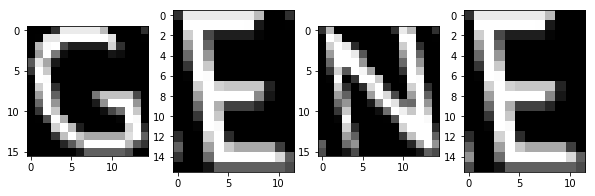

GENE


In [77]:
##  预测单词
def predict_captcha(captcha_image, net):
    subimages = segment_image(captcha_image)
    predicted_word = ""
    for subimage in subimages:
        subimage = resize(subimage, (20, 20), mode='reflect')
        outputs = net.activate(subimage.flatten())
        prediction = np.argmax(outputs)
        predicted_word += letters[prediction]
    return predicted_word
word = "GENE"
captcha = create_captcha(word, shear=0.2, )
print(predict_captcha(captcha, net))

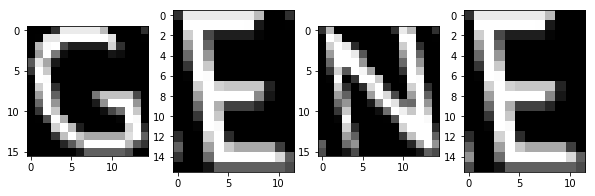

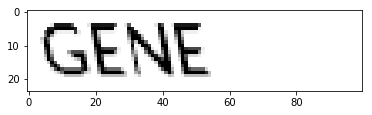

(True, 'GENE', 'GENE')

In [78]:
def test_prediction(word, net, shear=0.2):
    captcha = create_captcha(word, shear=shear)
    prediction = predict_captcha(captcha, net)
    #prediction = prediction[:4]
    plt.imshow(captcha, cmap='Greys')
    plt.show()
    return word == prediction, word, prediction
test_prediction(word, net)

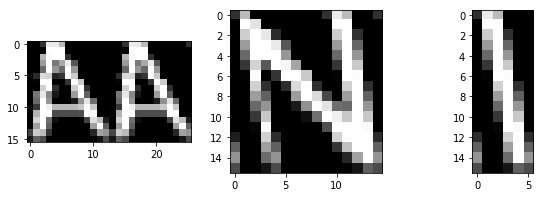

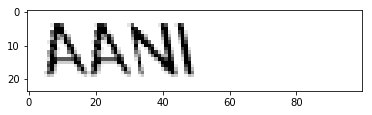

AANI WNI


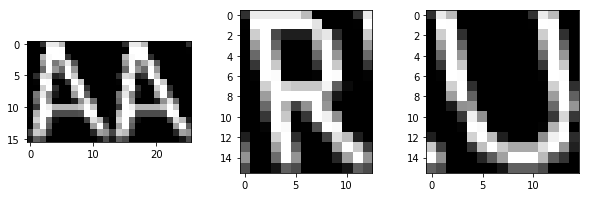

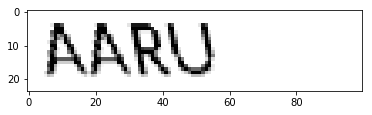

AARU WRU


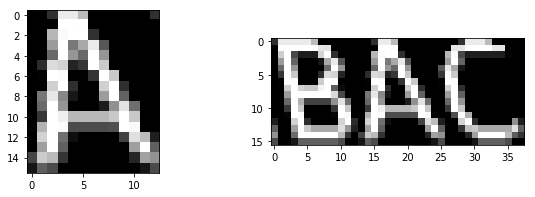

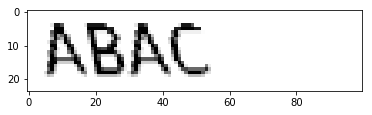

ABAC AA


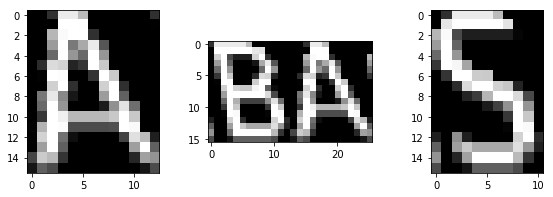

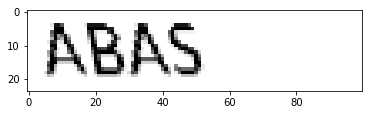

ABAS AAS


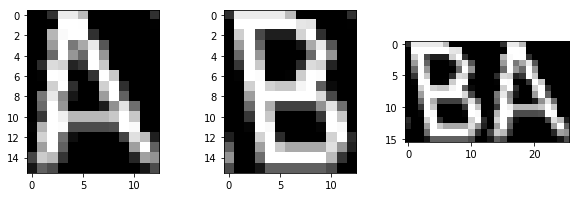

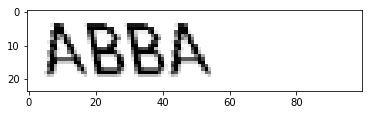

ABBA ABA


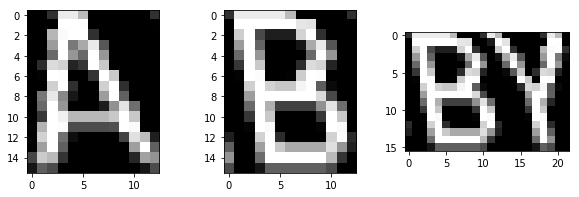

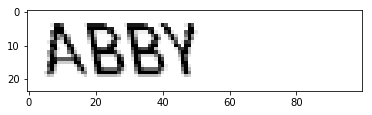

ABBY ABP


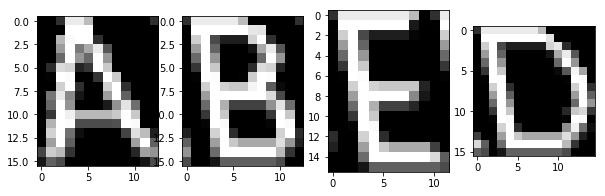

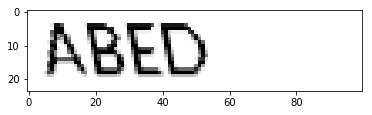

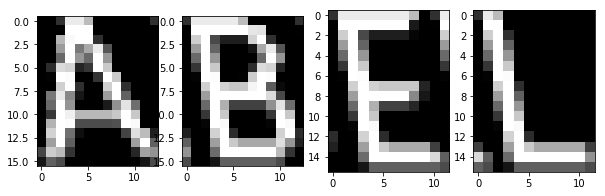

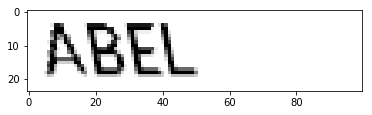

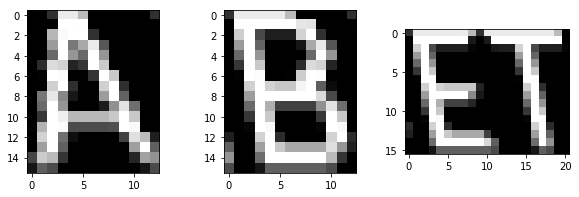

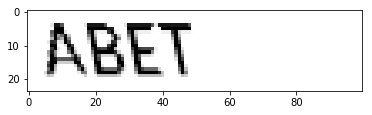

ABET ABT


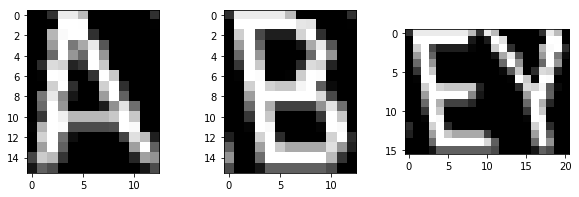

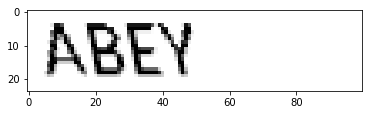

ABEY ABD
Number correct is 2
Number incorrect is 8


In [79]:
from nltk.corpus import words
valid_words = [word.upper() for word in words.words() if len(word) ==4]
num_correct = 0
num_incorrect = 0
for word in valid_words[:10]:
    correct, word, prediction = test_prediction(word, net, shear=0.2)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1
        print(word, prediction)
print("Number correct is {0}".format(num_correct))
print("Number incorrect is {0}".format(num_incorrect))

In [45]:
'''
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
plt.figure(figsize=(10, 10))
plt.imshow(cm)
tick_marks = np.arange(len(letters))
plt.xticks(tick_marks, letters)
plt.yticks(tick_marks, letters)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
'''

"\nfrom sklearn.metrics import confusion_matrix\ncm = confusion_matrix(np.argmax(y_test, axis=1), predictions)\nplt.figure(figsize=(10, 10))\nplt.imshow(cm)\ntick_marks = np.arange(len(letters))\nplt.xticks(tick_marks, letters)\nplt.yticks(tick_marks, letters)\nplt.ylabel('Actual')\nplt.xlabel('Predicted')\nplt.show()\n"

In [46]:
##  用词典提升正确率
from nltk.metrics import edit_distance
steps = edit_distance("STEP", "STOP")
print("The number of steps needed is: {0}".format(steps))

def compute_distance(prediction, word):
    return len(prediction) - sum(prediction[i] == word[i] for i in range(len(prediction)))
from operator import itemgetter
def improved_prediction(word, net, dictionary, shear=0.2):
    captcha = create_captcha(word, shear=shear)
    prediction = predict_captcha(captcha, net)
    prediction = prediction[:4]
    if prediction not in dictionary:
        distances = sorted([(word, compute_distance(prediction, word)) for word in dictionary], key=itemgetter(1))
        best_word = distances[0]
        prediction = best_word[0]
    return word == prediction, word, prediction

num_correct = 0
num_incorrect = 0
for word in valid_words:
    correct, word, prediction = improved_prediction(word, net, valid_words, shear=0.2)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1
        print(word, prediction)
print("Number correct is {0}".format(num_correct))
print("Number incorrect is {0}".format(num_incorrect))

The number of steps needed is: 1
AANI ANIL
AARU ARUI
ABAC AANI
ABAS AANI
ABBA ABAC
ABBY ABAC
ABET ABAC
ABEY ABAC
ABLE AIEL
ABLY ACYL
ABOX AIAS
ABUT ABAC
ACCA OAKY
ACER KERF
ACHE JEAN
ACHY JACK
ACID KIDS
ACIS KISH
ACLE CEDE
ACME KNEE
ACNE KNEE
ACOR CRAB
ACRE AREA
ACTA UANG
ACTS USAR
ACTU OAKY
ACYL RAAD
ADAD AKAL
ADAD AKAL
ADAI KAID
ADAM KANA
ADAR KARI
ADAT KATE
ADAW BAAL
ADAY KAYO
ADDA JACK
ADDA JACK
ADDU JACK
ADDY JYNX
ADET ATAP
ADIB KIBE
ADIN KINA
ADIT ATAP
ADMI KNIT
ADRY KADU
ADZE AJAR
AERY ABAC
AFAR FARE
AFAR FARE
AFFA FABA
AFFY FABA
AGAG RAAD
AGAL RAAD
AGAO RAAD
AGAR ARAB
AGAU JUAN
AGAZ AZHA
AGED CEDE
AGEE KEEK
AGEN KEND
AGER KERF
AGHA JACK
AGIB KIBE
AGIO AION
AGLA JACK
AGOG GABE
AGON ANAL
AGRA KADU
AGRE AREA
AGUA GUAN
AGUE DUEL
AHEM HEND
AHET ATAP
AHEY ADAD
AHIR HIRE
AHOM HONE
AHOY HOYA
AHUM HUNG
AINT AIAS
AINU ABIE
AIRA AIAS
AIRT AFFA
AIRY AIAS
AJAR ARAB
AJOG XEMA
AKAL XEMA
AKAN INBE
AKEE ABED
AKEY ADAD
AKHA WAAC
AKIA AIAS
AKIM AINT
AKIN AINT
AKKA IAMB
AKOV IVAN
AKRA AANI
AKRA AA

CURB ARBA
CURD ARDU
CURE TREE
CURL ORLE
CURN ARNA
CURR ARRY
CURT AFAR
CURT AFAR
CUSH JACK
CUSK JACK
CUSP APAR
CUSS ASAK
CUTE VEAL
CUVY JACK
CUYA JACK
CYAN AANI
CYKE ZEAL
CYMA ONAN
CYME ONER
CYST OSSE
CZAR ARAB
DACE AKEE
DADA AKAL
DADA AKAL
DADE AKEE
DADO DRAB
DADU AMAH
DAFF AFAR
DAFT AFAR
DAGO AJAR
DAGS DASH
DALE AWEE
DALE AWEE
DALI AWIN
DALK AJAR
DALT DATA
DAMA DANA
DAME DANE
DAMN DAIN
DANA DABB
DAND DAIL
DANG DAIL
DANK BAAL
DART DAFF
DASH BAHO
DAUD DAZA
DAUT DATA
DAUW DABB
DAVE DATA
DAVY CAPE
DAVY CAPE
DAWN DAIN
DAWN DAIN
DAZA DADA
DAZE DABB
DAZY DADA
DEAD DIAL
DEAF ATAP
DEAL AJAR
DEAN DANA
DEAN DANA
DEAR DARD
DEBT DEVA
DECK BEJA
DEDO DAZA
DEEM BEEN
DEFT BETA
DEFY DEVA
DELF BEJA
DELL BEJA
DEME DENE
DEMI BENI
DEMY DEAD
DENT DEAD
DENY DEPA
DERM DERN
DESK BEJA
DEUL BEJA
DEVA ATAP
DEWY AJAR
DHAI JAIL
DHAK JACK
DHAN JANE
DHAW BAAL
DHOW JOUG
DIAL DIXY
DICH BIJA
DICK BIJA
DICK BIJA
DIDO BIZZ
DIEM BIEN
DIET DITA
DIKA DIAL
DILL BIJA
DIME DINE
DING DAIL
DINK DIAL
DINT DIKA
DIOL BIZZ
DIRT BIFF


HULL AZHA
HULU HAUL
HUMA BUNA
HUME AUNE
HUNG HUIA
HUNH BUHL
HUNK BUAL
HUNT HUKE
HURA BUAL
HURA BUAL
HURT HUFF
HUSE HAEC
HUSH AJAR
HUSK AJAR
HUSO AJAR
HUSS HASH
HUZZ AZHA
HYKE AEON
HYLA IAMB
HYLE JEAN
HYMN ANNA
HYNE ANES
HYPO HICK
IBAD IIWI
IBAN AANI
IBEX IBAD
ICHO AJOG
ICHU IJMA
ICON IONE
IDLE IBEX
IDLY IDYL
IDOL IXIA
IDYL IDIC
IFFY AHEM
IIWI IWIS
IKAT BATE
IKEY IKAT
IKRA IKAT
ILEX IKRA
ILKA IJMA
ILLY IDYL
IMAM ANAN
IMBE INBE
IMMI IONI
IMPY IMPI
INBY IMPI
INCA IODO
INCH IJMA
INDE AIEL
INDY IDYL
INGA IJMA
INKS IIWI
INKY IIWI
INLY IDYL
INTO AKOV
IODO IJMA
IOWA IOTA
IRAN AANI
IRAQ ITCH
IRMA ARNA
IROK IRAN
ISBA ASAK
ISLE IBEX
ISMY ASKR
ITCH AJAR
ITEA AJAR
ITEM TEND
ITEN TEND
ITER TERA
ITMO ANOA
ITYS PSHA
ITZA TAAL
IVAN JANE
IVIN ANAL
IWIS WISE
IZAR ADRY
IZAR ADRY
IZLE IBEX
IZZY IZAR
JACK AANI
JACK AANI
JACU AANI
JADE AEON
JADY AYAH
JAGA AANI
JAIL AILE
JAIN AINT
JAKE AEON
JAKE AEON
JAKO XEMA
JAMA ANAL
JAMB ANBA
JAMI ANIL
JANE ANES
JANE ANES
JANK AANI
JANN ANNA
JAOB IBAD
JAPE APER
JARA AANI


NABK HAAB
NABS ABSI
NABU ABUT
NACE AEON
NACH IAMB
NAEL HELE
NAGA IAMB
NAGA IAMB
NAID HIDE
NAIF BIFF
NAIG HIGH
NAIK HIKE
NAIL HILL
NAIM HIND
NAIN HIND
NAIO AION
NAIR HIRE
NAIS HISH
NAJA AANI
NAKE AEON
NAKO IAMB
NAMA ANAL
NAME ANES
NANA AJAR
NANA AJAR
NANE ANES
NANT AKAL
NAOS IAMB
NAOS IAMB
NAPA APAR
NAPE APER
NAPU HICK
NARD ARDU
NARK HAKE
NARR ARRY
NARY HAAB
NASH JHOW
NASI ISIS
NAST ASAK
NATE ATEF
NATR ATRY
NATT ATAP
NAUT ATAP
NAVE ATAP
NAVY APAR
NAWT JUAN
NAZE AJAR
NAZI AZHA
NEAL AJAR
NEAL AJAR
NEAP NAPA
NEAT NATE
NECK NEJD
NEEM BEEN
NEET NETE
NEJD AJAR
NELL NEJD
NEMA BENA
NESH BEHN
NEST NESE
NETE ATEF
NETH AJAR
NETI ATIK
NEVE AXAL
NEVO AXAL
NEWS NASH
NEWT ATAP
NEXT ATAP
NGAI JIBE
NHAN HAND
NICK BIJA
NICK BIJA
NIGH KIHO
NILS BIJA
NINA KIHO
NING LIIN
NIOG NIGH
NITO ATOM
NIZY NIDE
NOAH AHEM
NOAM AANI
NOBS ABSI
NOCK IAMB
NODE CEDE
NODI CINE
NOEL BELA
NOEL BELA
NOIL AILE
NOIR AIRA
NOLL CAAM
NOLL CAAM
NOLO COAK
NOMA ANAL
NOME INEZ
NONA AHEM
NONE INEZ
NOOK IAMB
NOON ANAL
NOOP APAR
NOPE APER


SHAI HAIK
SHAM HAND
SHAM HAND
SHAN HAND
SHAN HAND
SHAP HAPI
SHAT HATE
SHAW HAAB
SHAW HAAB
SHAY HAYA
SHEA AJAR
SHED CEDE
SHEE HEED
SHEL HELE
SHEN HEND
SHER HERB
SHIH HEHE
SHIK HIKE
SHIM HIND
SHIN HIND
SHIP HIPE
SHIV AJAR
SHLU ALUM
SHOA HOAR
SHOD AZHA
SHOE HOER
SHOG AGAG
SHOO AZHA
SHOP HOPE
SHOQ AXAL
SHOR HORA
SHOR HORA
SHOT HOTI
SHOU AZHA
SHOW HOUR
SHUG AGAG
SHUL AJAR
SHUN HUNG
SHUT ATAP
SIAL BIXA
SIAM DIAN
SICK BIJA
SIFT SITA
SIGH KIHO
SIKA SIAK
SIKA SIAK
SIKH KIHO
SILK BIJA
SILL BIJA
SIMA SINA
SIME SINE
SINA KIHO
SIND LIIN
SING LIIN
SINH KIHO
SINK SIAK
SIOL SIZE
SISH KIHO
SIST SISE
SITA STAB
SITE STEG
SITH AFAR
SIUM SCUN
SIVA AJAR
SIVA AJAR
SIZE BIJA
SIZY SIDA
SIZZ SIDA
SKAG AANI
SKAL AANI
SKAT ITCH
SKAT ITCH
SKAW IAMB
SKEE JEEL
SKEF JEFF
SKEG BEGO
SKEL JELL
SKEN BENA
SKEO AEON
SKEP CEPA
SKER JERK
SKEW AJAR
SKEY ADAD
SKID AIDE
SKIL JILL
SKIM JINA
SKIN JINA
SKIP CIPO
SKIP CIPO
SKIT ATAP
SKIV AJAR
SKOO JACK
SKUA IAMB
SKUN INBE
SKYE AEON
SLAB ABAC
SLAD JACK
SLAE JEAN
SLAG JACK
SLAM ANAL


WEED DEED
WEEK BEEK
WEEL FEEL
WEEN BEEN
WEEP DEEP
WEET BETA
WEFT BETA
WEGA BEJA
WEIR HEIR
WEKA BEAD
WEKI REKI
WELD UNZE
WELF BEJA
WELK BEJA
WELL BEJA
WELS BEJA
WELT BELT
WEND BEID
WEND BEID
WENE BENE
WENT REKI
WEPT BETA
WERE BERE
WERF KERF
WERI BERI
WERT DEFT
WESE MESE
WEST BESA
WETA UTAH
WEVE AXAL
WEZN BEAD
WHAM FANA
WHAN FANA
WHAP CAPE
WHAR FARE
WHAT FATE
WHAU FAUN
WHEE FEED
WHEN FEND
WHET ATAP
WHEW AJAR
WHEY ADAD
WHID FIDE
WHIG BIGA
WHIG BIGA
WHIM FIND
WHIN FIND
WHIP CIPO
WHIR FIRE
WHIT ATAP
WHIT ATAP
WHIZ FIZZ
WHOA FOAL
WHOM FONO
WHOO AZHA
WHOP COPA
WHUD AZHA
WHUN FUND
WHUP DUPE
WHUZ AZHA
WHYO MOAN
WICE BICE
WICK BIJA
WIDE AIDE
WIDU BIZZ
WIFE FIFE
WILD BIZZ
WILE AILE
WILK BIJA
WILL BIJA
WILL BIJA
WILT GILT
WILY UILY
WIME BINE
WIND LIIN
WIND LIIN
WINE BINE
WING LIIN
WINK AIAS
WINT BIKE
WINY CIPO
WIPE HIPE
WIPS BIWA
WIRD BIRD
WIRE AIRE
WIRL BIRL
WIRR BIRR
WIRY AIAS
WISE CISE
WISH KIHO
WISP LISP
WISS DISS
WIST CISE
WITE ATEF
WITH AFAR
WIVE AXAL
WOAD BOKE
WOAK BOAR
WOAN COAN
WODE ULEX
